In [1]:
!pip install folktables

You should consider upgrading via the '/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/bin/python -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from utils.model_tuning_utils import test_ML_models

/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [4]:
%matplotlib inline

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

### Python & Library Versions

In [5]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("sklearn", sklearn.__version__),
             ("seaborn", sns.__version__)
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))


3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0] 

library    version
------------------
matplotlib  3.5.2
numpy       1.21.2
pandas      1.3.3
sklearn     1.1.1
seaborn     0.11.2


### Read a dataset

In [6]:
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["FL"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)

### Data Pre-processing

In [7]:
ACSEmployment.target

'ESR'

In [8]:
ACSEmployment.features

['AGEP',
 'SCHL',
 'MAR',
 'RELP',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'SEX',
 'RAC1P']

In [9]:
features.shape, acs_data.shape

((196828, 16), (196828, 284))

In [10]:
# Create pandas datafrane with features and label column
full_df = acs_data[ACSEmployment.features + [ACSEmployment.target]].copy()
full_df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,54,16.0,1,0,2,NaN,4,1.0,4.0,1,2,2,2,2.0,1,1,1.0
1,50,16.0,1,1,2,NaN,4,1.0,4.0,1,2,2,2,2.0,2,1,3.0
2,24,21.0,5,2,1,NaN,4,1.0,4.0,1,2,1,2,1.0,1,1,1.0
3,36,19.0,5,0,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,1.0
4,19,19.0,5,2,1,NaN,1,1.0,4.0,1,1,1,2,2.0,2,8,6.0


In [11]:
# Convert label column to binary format
full_df['LABEL_ESR'] = ACSEmployment.target_transform(full_df[ACSEmployment.target])
full_df.drop([ACSEmployment.target], axis=1, inplace=True)

In [12]:
full_df['AGEP'].describe()

count    196828.000000
mean         44.721285
std          23.990470
min           0.000000
25%          24.000000
50%          47.000000
75%          64.000000
max          95.000000
Name: AGEP, dtype: float64

In [13]:
full_df.isnull().sum()

AGEP              0
SCHL           5043
MAR               0
RELP              0
DIS               0
ESP          164359
CIT               0
MIG            1624
MIL           32393
ANC               0
NATIVITY          0
DEAR              0
DEYE              0
DREM           8369
SEX               0
RAC1P             0
LABEL_ESR         0
dtype: int64

In [14]:
full_df.fillna(0, inplace = True)
full_df.isnull().sum()

AGEP         0
SCHL         0
MAR          0
RELP         0
DIS          0
ESP          0
CIT          0
MIG          0
MIL          0
ANC          0
NATIVITY     0
DEAR         0
DEYE         0
DREM         0
SEX          0
RAC1P        0
LABEL_ESR    0
dtype: int64

### Data Profiling

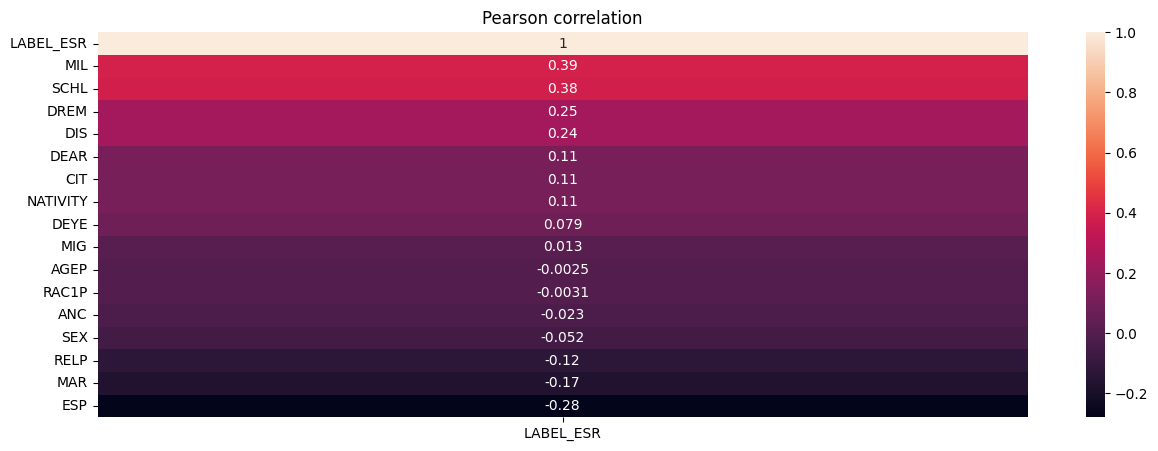

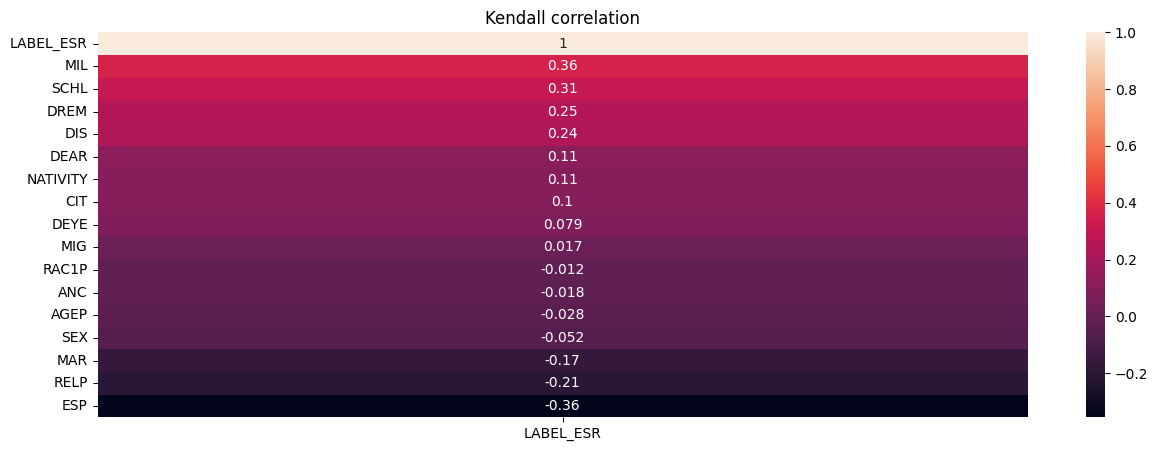

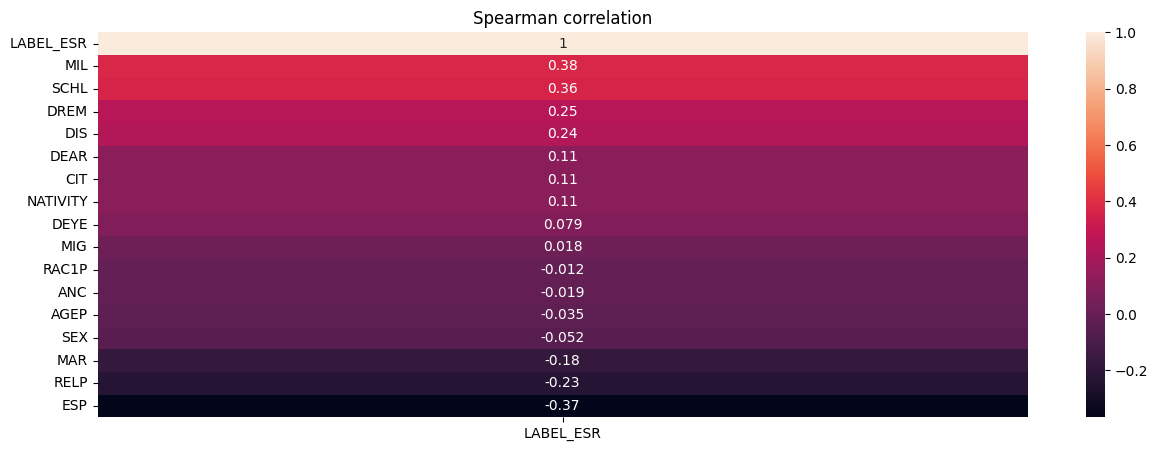

In [15]:
# Look at the feature correlation with 'LABEL_ESR' column
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(
        full_df.corr(method=method)[['LABEL_ESR']]\
            .sort_values(by='LABEL_ESR', ascending=False),
        ax=ax,
        annot=True
    )
    ax.set_title(f'{method.capitalize()} correlation')
    plt.show()


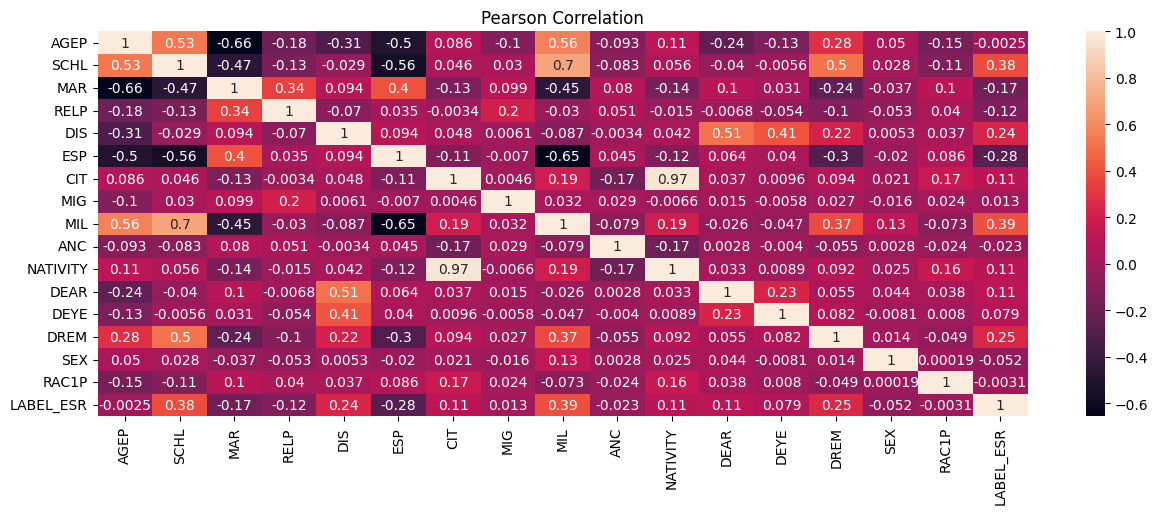

In [ ]:
# Look at correlations among features
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(full_df.corr(method=method), ax=ax, annot=True)
    ax.set_title(f'{method.capitalize()} Correlation')
    plt.show()


In [ ]:
# Look at densities of each column
for column in full_df.columns:
    plt.figure()
    sns.distplot(full_df[column])

### Analyze Feature Importance

In [ ]:
SEED = 42
features_df = full_df.drop('LABEL_ESR', axis=1, inplace=False)
target_df = full_df['LABEL_ESR']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
X_train_full.shape, X_test_full.shape

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_full, y_train_full)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(features_df.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Train a baseline model

In [ ]:
# Create a feature dataframe based on the feature correlation with 'LABEL_ESR' and feature importance
feature_cols = ['MIL', 'DIS', 'ESP', 'MAR', 'RELP', 'ANC']
features_df = pd.get_dummies(full_df[feature_cols], columns=feature_cols)
features_df['AGEP'] = full_df['AGEP']
features_df['SCHL'] = full_df['SCHL']
target_df = full_df['LABEL_ESR']
features_df.head()

In [ ]:
features_df.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape

In [ ]:
n_folds = 3
samples_per_fold = len(y_test)
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [ ]:
config_models = [
    {
        'model_name': 'RandomForestClassifier',
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            "bootstrap": [True],
            "max_depth": [10],
            "n_estimators": [30],
            "max_features": [0.6]
        }
    },
    {
        'model_name': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            "max_depth": [10],
            "max_features": [0.6],
            "criterion": ["gini"]
        }
    },
    # For XGBoost parameters tuning we used this article --
    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    {
        'model_name': 'XGBClassifier',
        'model': XGBClassifier(random_state=SEED),
        'params': {
            'learning_rate': [0.1],
            'n_estimators': [200],
            'max_depth': [5],
            'objective':  ['binary:logistic'],
        }
    }
]

In [ ]:
ML_results_df = test_ML_models(best_results_df, config_models, n_folds, samples_per_fold,
                               X_train, y_train, X_test, y_test, "Folktables [LA]", show_plots=True, debug_mode=True)
ML_results_df

In [ ]:
for index, row in ML_results_df.iterrows():
  print(f'\n\nModel name: {row["Model_Name"]}')
  pprint(row['Model_Best_Params'])